In [1]:
import os
import numpy as np

# from torch.utils.data import DataLoader, Dataset

from preprocess import resize_input, train_test_split, read_raw
from ear_triplet import EarTriplet

import cv2
import torch
import torchvision

In [2]:
train_dataset = torchvision.datasets.MNIST(
    "/files/",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            #    torchvision.transforms.Normalize(
            #      (0.1307,), (0.3081,))
        ]
    ),
)

eval_dataset = torchvision.datasets.MNIST(
    "/files/",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            #    torchvision.transforms.Normalize(
            #      (0.1307,), (0.3081,))
        ]
    ),
)

label: 5


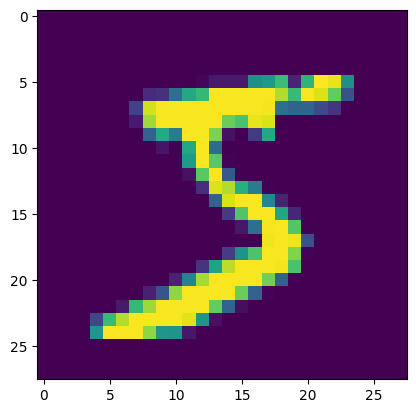

In [3]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]

plt.imshow(train_dataset.data[0])
print("label:", label)

In [4]:
def split_triplets(X, y):
    # Constraint: anchor and positive must be the same person
    X, y = np.array(X), np.array(y)
    print("Classes: ", len(np.unique(y)))

    # Key has a list of indices of instances of that label
    # label_to_indices[label] returns indices of all the instances of class=label
    label_to_indices = {label: np.where(y == label)[0] for label in np.unique(y)}

    for key in label_to_indices.keys():
        np.random.shuffle(label_to_indices[key])

    an, pos, neg = [], [], []

    # For each class
    for i, label in enumerate(label_to_indices.keys()):
        subarray_size = len(label_to_indices[label]) // 2

        # Get random negative classes; negs = array of classes
        negs = list(label_to_indices.keys()).copy()
        negs.remove(label)
        print(negs, subarray_size)
        negs = np.random.choice(negs, size=subarray_size, replace=True)
        while label in negs:
            negs = np.random.choice(
                list(label_to_indices.keys()), size=subarray_size, replace=False
            )

        # anchor and positive have label = label and negative is random
        an.extend(label_to_indices[label][:subarray_size])
        pos.extend(label_to_indices[label][subarray_size:][:subarray_size])

        # Negative = random class od vseh ostalih, vzami random instanco iz vsakega
        for neg_label in negs:
            neg.extend(np.random.choice(label_to_indices[neg_label], size=1))

    print(len(an), len(pos), len(neg))

    # Use the resulting arrays of indices to get the split arrays
    anchor_data, anchor_labels = X[an], y[an]
    positive_data, positive_labels = X[pos], y[pos]
    negative_data, negative_labels = X[neg], y[neg]

    return (
        (anchor_data, anchor_labels),
        (positive_data, positive_labels),
        (negative_data, negative_labels),
    )

In [5]:
X_train, X_test, y_train, y_test = [], [], [], []

for item in train_dataset:
    img, label = item

    X_train.append(img)
    y_train.append(label)

for item in eval_dataset:
    img, label = item

    X_test.append(img)
    y_test.append(label)

In [6]:
# X_train, X_eval, y_train, y_eval = train_test_split(data_dict)

In [7]:
len(X_train)

60000

In [8]:
X_train = resize_input(X_train, 64, mode="train")

c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
train_triplets = split_triplets(X_train, y_train)

train_anc, train_pos, train_neg = train_triplets

train_dataset = EarTriplet(
    train_anc[0], train_anc[1], train_pos[0], train_pos[1], train_neg[0], train_neg[1]
)

len(train_dataset.anchor_data), len(train_dataset.anchor_labels), len(
    train_dataset.positive_data
), len(train_dataset.positive_labels), len(train_dataset.negative_data), len(
    train_dataset.negative_labels
)

Classes:  10
[1, 2, 3, 4, 5, 6, 7, 8, 9] 2961
[0, 2, 3, 4, 5, 6, 7, 8, 9] 3371
[0, 1, 3, 4, 5, 6, 7, 8, 9] 2979
[0, 1, 2, 4, 5, 6, 7, 8, 9] 3065
[0, 1, 2, 3, 5, 6, 7, 8, 9] 2921
[0, 1, 2, 3, 4, 6, 7, 8, 9] 2710
[0, 1, 2, 3, 4, 5, 7, 8, 9] 2959
[0, 1, 2, 3, 4, 5, 6, 8, 9] 3132
[0, 1, 2, 3, 4, 5, 6, 7, 9] 2925
[0, 1, 2, 3, 4, 5, 6, 7, 8] 2974
29997 29997 29997


(29997, 29997, 29997, 29997, 29997, 29997)

In [10]:
torch.save(train_dataset, "data/train_dataset.pt")

In [11]:
X_eval = resize_input(X_test, 64, mode="test")

eval_triplets = split_triplets(X_eval, y_test)

eval_anc, eval_pos, eval_neg = eval_triplets

eval_dataset = EarTriplet(
    eval_anc[0], eval_anc[1], eval_pos[0], eval_pos[1], eval_neg[0], eval_neg[1]
)

Classes:  10
[1, 2, 3, 4, 5, 6, 7, 8, 9] 490
[0, 2, 3, 4, 5, 6, 7, 8, 9] 567
[0, 1, 3, 4, 5, 6, 7, 8, 9] 516
[0, 1, 2, 4, 5, 6, 7, 8, 9] 505
[0, 1, 2, 3, 5, 6, 7, 8, 9] 491
[0, 1, 2, 3, 4, 6, 7, 8, 9] 446
[0, 1, 2, 3, 4, 5, 7, 8, 9] 479
[0, 1, 2, 3, 4, 5, 6, 8, 9] 514
[0, 1, 2, 3, 4, 5, 6, 7, 9] 487
[0, 1, 2, 3, 4, 5, 6, 7, 8] 504
4999 4999 4999


In [12]:
torch.save(eval_dataset, "data/eval_dataset.pt")